In [63]:
import numpy as np
import sys
print(sys.version)

import logging.config
from sklearn.utils import shuffle

import numpy as np
from os import path

import seaborn as sns

import quandl

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation
from tensorflow.keras import Sequential, callbacks
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import RMSprop

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from DataLoader import DataLoader
from MarketData import QuandlMarketDataSource, RedditMarketDataSource, BloombergMarketDataSource

from learning.BasicLearning import RbfClassifier
from utilities import Constants
from utilities.Utilities import Utilities
from MarketData import BloombergMarketDataSource

3.7.0 (v3.7.0:1bf9cc5093, Jun 26 2018, 23:26:24) 
[Clang 6.0 (clang-600.0.57)]


In [34]:
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
plt.style.use("seaborn")

In [35]:
from Experiment import *

In [36]:
key_dir = "/Users/tianyudu/Documents/UToronto/Course/ECO499/quandl_api.txt"
with open(key_dir, "r") as f:
    key = f.readline()

In [37]:
# Load path
sentiment_location = path.join(Constants.DATASETS_MARKET, "FinArticles/psenti/all.results.csv")
price_source = "quandl"
stock = "JPM"

x_data, y_data = get_data(False, sentiment_location, price_source, stock)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state=42)

2019-11-10 17:00:11,621 - utilities - INFO - Loading Stock [JPM]...


/Users/tianyudu/Documents/UToronto/Course/ECO499/ugthesis/replications/src/DataLoader.py:67: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  articles = articles.groupby(pd.TimeGrouper('D')).mean()
/Users/tianyudu/Documents/UToronto/Course/ECO499/ugthesis/replications/src/PortfolioBasic/stockstats.py:387: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  lambda x: np.fabs(x - x.mean()).mean())


In [89]:
df = pd.read_csv("/Users/tianyudu/Documents/UToronto/Course/ECO499/ugthesis/replications/DataSets/Market/reddit/DJIA_table.csv", index_col=0)

In [90]:
df.index = pd.to_datetime(df.index, format="%Y-%m-%d")

In [117]:
djia_ft1 = df[np.logical_and(df.index >= "2011-04-01", df.index <= "2011-12-25")]
len(djia_ft1)
# djia_ft1.to_csv("./djia_ft1.csv", header=True, index=True)

186

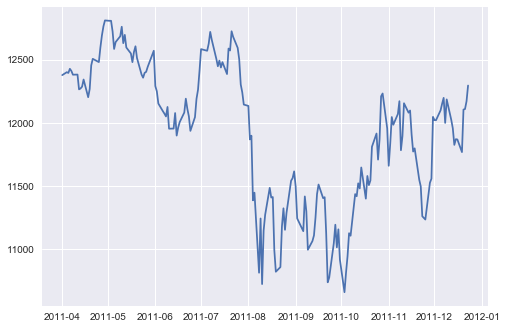

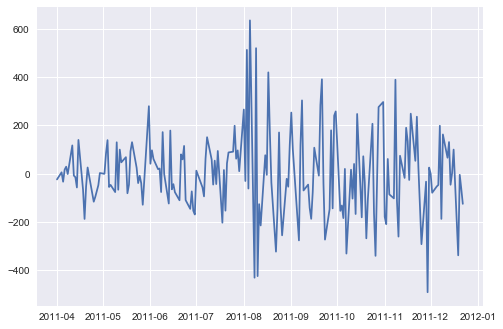

In [118]:
plt.plot(djia_ft1.Close)
plt.show()
plt.plot(djia_ft1.Close.diff())
plt.show()

In [119]:
djia_ft1.head()

Open          High           Low         Close     Volume  \
Date                                                                            
2011-12-23  12169.879883  12297.440430  12169.799805  12294.000000   80420000   
2011-12-22  12107.589844  12182.709961  12107.370117  12169.650391  151610000   
2011-12-21  12103.580078  12119.700195  11999.440430  12107.740234  163250000   
2011-12-20  11769.209961  12117.129883  11768.830078  12103.580078  165180000   
2011-12-19  11866.540039  11925.879883  11735.190430  11766.259766  135170000   

               Adj Close  
Date                      
2011-12-23  12294.000000  
2011-12-22  12169.650391  
2011-12-21  12107.740234  
2011-12-20  12103.580078  
2011-12-19  11766.259766

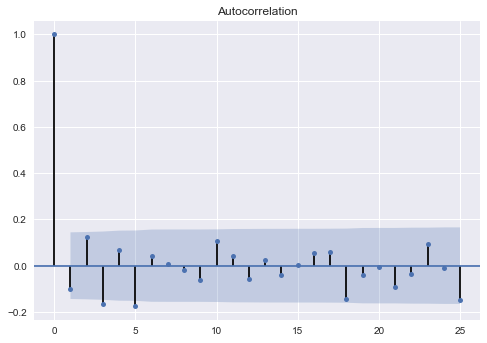

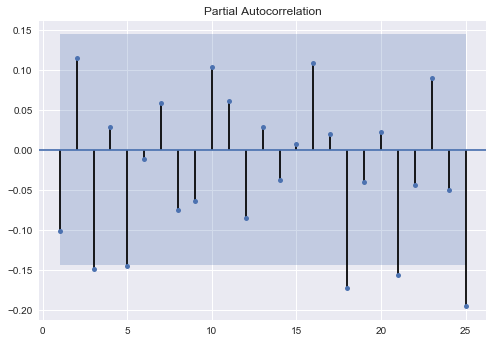

In [122]:
# Stationary test.
sm.graphics.tsa.plot_acf(np.diff(djia_ft1.Close), lags=25)
plt.savefig("/Users/tianyudu/Documents/UToronto/Course/ECO499/3_Replication/figures/acf_djia_ft1.png")
# plt.show()
sm.graphics.tsa.plot_pacf(np.diff(djia_ft1.Close), lags=25, zero=False)
# plt.show()
plt.savefig("/Users/tianyudu/Documents/UToronto/Course/ECO499/3_Replication/figures/pacf_djia_ft1.png")

In [116]:
import statsmodels.api as sm


class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None

    def ADF_Stationarity_Test(self, timeseries, printResults = True):

        #Dickey-Fuller test:
        adfTest = sm.tsa.stattools.adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value

            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

In [53]:
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(np.diff(djia_ft1.Close), printResults = True)
print("Is the time series stationary at sig level {}? {}".format(sTest.SignificanceLevel, sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -8.547898e+00
P-Value                 9.394158e-14
# Lags Used             2.000000e+00
# Observations Used     1.820000e+02
Critical Value (1%)    -3.466800e+00
Critical Value (5%)    -2.877555e+00
Critical Value (10%)   -2.575308e+00
dtype: float64
Is the time series stationary at sig level 0.05? True


In [54]:
result = sm.tsa.stattools.adfuller(np.diff(djia_ft1.Close))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.547898
p-value: 0.000000
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575


In [55]:
loader = DataLoader()
source = QuandlMarketDataSource()
x_data, y_data = loader.load_data(
    stock, 5,
    source=source,
    sentiment_location=sentiment_location,
    full_articles=False,
    from_date="2011-04-01",
    to_date="2011-12-25"
)

2019-11-10 17:08:21,719 - utilities - INFO - Loading Stock [JPM]...


/Users/tianyudu/Documents/UToronto/Course/ECO499/ugthesis/replications/src/DataLoader.py:67: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  articles = articles.groupby(pd.TimeGrouper('D')).mean()
/Users/tianyudu/Documents/UToronto/Course/ECO499/ugthesis/replications/src/PortfolioBasic/stockstats.py:387: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  lambda x: np.fabs(x - x.mean()).mean())


In [56]:
x_data, y_data = loader.load_data(stock, 5,
                                      source=source,
                                      sentiment_location=sentiment_location,
                                      full_articles=True,
                                      from_date='2011-04-01', to_date='2011-12-25')
scaler = preprocessing.StandardScaler()
scaler.fit(x_data)
x_data = scaler.transform(x_data)

2019-11-10 17:08:25,336 - utilities - INFO - Loading Stock [JPM]...


In [57]:
import pandas as pd
import numpy as np
from functools import reduce

from PortfolioBasic.stockstats import StockDataFrame

from MarketData import QuandlMarketDataSource, MarketData
from PortfolioBasic.Definitions import HeaderFactory
from PortfolioBasic.Technical.Indicators import RsiIndicator, MomentumIndicator, MACDIndicator,  \
    CombinedIndicator, BollingerIndicator, Williams, CommodityChannelIndex, TripleExponentialMovingAverage, \
    AverageDirectionalIndex, AverageTrueRange

In [58]:
full_articles = True

In [59]:
articles = pd.read_csv(sentiment_location, na_values=["nan"])
articles.head()
articles.Date = pd.to_datetime(articles.Date, format='%d/%m/%Y %H:%M:%S')
articles.set_index('Date', inplace=True)
articles.reindex()
articles.sort_index(ascending=True, inplace=True)

In [60]:
articles.head()

Id  Original  Calculated  TotalSentimentWords  Anger  \
Date                                                                            
2010-12-23 22:42:31  1_3229         5    1.640677                  439     20   
2010-12-23 22:47:08  1_3230         5    1.430244                  645     22   
2010-12-23 23:19:40  1_3231         5    2.971431                  395      9   
2010-12-27 20:27:08  1_3232         5    2.784272                  427     16   
2010-12-27 21:53:53  1_3233         5    1.000000                  400     18   

                     Anticipation  Disgust  Fear  Joy  Sadness  Surprise  \
Date                                                                       
2010-12-23 22:42:31            40       16    31   30       21        13   
2010-12-23 22:47:08            43       18    31   36       27        24   
2010-12-23 23:19:40            19        9    15   25       13        14   
2010-12-27 20:27:08            28       19    18   18       20         8   
2010-12-27 21:53:53            19       18    28   16       25         7   

                     Trust  TotalWords  
Date                                    
2010-12-23 22:42:31     41         988  
2010-12-23 22:47:08     64        1361  
2010-12-23 23:19:40     40         892  
2010-12-27 20:27:08     46         903  
2010-12-27 21:53:53     46         925

In [61]:
if full_articles:
    articles['Anger'] /= articles['TotalWords']
    articles['Anticipation'] /= articles['TotalWords']
    articles['Disgust'] /= articles['TotalWords']
    articles['Fear'] /= articles['TotalWords']
    articles['Joy'] /= articles['TotalWords']
    articles['Sadness'] /= articles['TotalWords']
    articles['Surprise'] /= articles['TotalWords']
    articles['Trust'] /= articles['TotalWords']
    articles.drop(columns=['Original', 'Original', 'TotalWords', 'TotalSentimentWords', 'Id'], inplace=True)
else:
    articles.drop(columns=['Original', 'Original', 'TotalWords', 'TotalSentimentWords', 'Id', 'Anger',
                           'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust'], inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWar

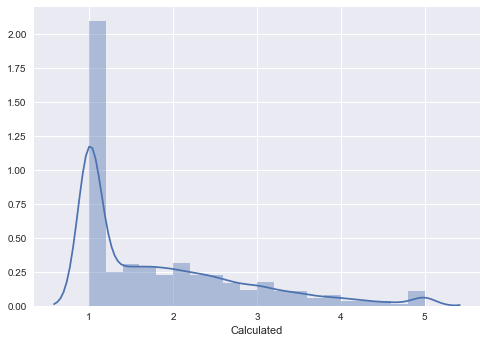

In [64]:
# articles['Calculated'] = ((articles['Calculated'] - 1) / 2) - 1
articles.head()
sns.distplot(articles.Calculated, bins=20)
plt.show()

In [65]:
articles['Calculated'] = ((articles['Calculated'] - 1) / 2) - 1
articles = articles.groupby(pd.Grouper(freq='D')).mean()
articles.head()

Calculated     Anger  Anticipation   Disgust      Fear       Joy  \
Date                                                                           
2010-12-23   -0.492941  0.015499      0.031127  0.013170  0.023657  0.028281   
2010-12-24         NaN       NaN           NaN       NaN       NaN       NaN   
2010-12-25         NaN       NaN           NaN       NaN       NaN       NaN   
2010-12-26         NaN       NaN           NaN       NaN       NaN       NaN   
2010-12-27   -0.279097  0.014124      0.024848  0.014489  0.019207  0.018840   

             Sadness  Surprise     Trust  
Date                                      
2010-12-23  0.018556  0.015496  0.044455  
2010-12-24       NaN       NaN       NaN  
2010-12-25       NaN       NaN       NaN  
2010-12-26       NaN       NaN       NaN  
2010-12-27  0.019606  0.007701  0.040728

In [66]:
np.mean(np.isnan(articles.Calculated))

0.6538711776187378

In [67]:
raw_price_df = source.get_stock_data(stock)

2019-11-10 17:08:47,198 - utilities - INFO - Loading Stock [JPM]...


In [68]:
raw_price_df.head()

Open      High       Low     Close    Volume
date                                                        
1983-12-30  3.074327  3.109262  3.039391  3.074327  211500.0
1984-01-03  3.070135  3.091795  3.047776  3.074327  385501.5
1984-01-04  3.133019  3.204986  3.091795  3.204986  292500.0
1984-01-05  3.270665  3.310491  3.231537  3.310491  344101.5
1984-01-06  3.275556  3.310491  3.240620  3.275556  194400.0

In [69]:
indicators = CombinedIndicator((
            MomentumIndicator(1),
            MomentumIndicator(5),
            BollingerIndicator(),
            MACDIndicator(),
            CommodityChannelIndex(),
            AverageDirectionalIndex(),
            TripleExponentialMovingAverage(),
            AverageTrueRange(),
            RsiIndicator(),
            Williams()
            ))

In [70]:
# Take FT-1 dataset daterange.
from_date='2011-04-01'
to_date='2011-12-25'

In [71]:
ma = [50, 100, 200]
days=5
market = MarketData(stock, raw_price_df, days=days, ma=ma, indicator=indicators, df_additional=articles)
# Price dataframe is cleaned, hmm, somehow.
price_df = market.get_stock_data()

/Users/tianyudu/Documents/UToronto/Course/ECO499/ugthesis/replications/src/PortfolioBasic/stockstats.py:387: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  lambda x: np.fabs(x - x.mean()).mean())


In [72]:
X, y = market.get_binary_df(price_df, days=days, from_date=from_date, to_date=to_date)

0


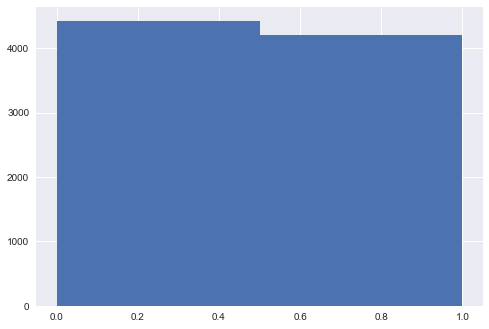

In [73]:
df = raw_price_df
print(np.where(df["Close"].shift(-1) <= df["Close"], 0, 1)[0])
plt.hist(np.where(df["Close"].shift(-1) <= df["Close"], 0, 1), bins=2)
plt.show()

In [104]:
price_df_ft1 = price_df[np.logical_and(price_df.index >= "2011-04-01", price_df.index <= "2011-12-25")]

In [109]:
price_df_ft1.head()

Open       High        Low      Volume       Pct  Direction  \
date                                                                           
2011-04-01  38.833054  39.108347  38.524391  25387300.0  0.005423          1   
2011-04-04  38.681904  39.017393  38.623193  15708000.0  0.005178          1   
2011-04-05  38.723840  39.227074  38.623193  21058400.0  0.005179          1   
2011-04-06  39.260622  40.032248  39.109652  31203300.0  0.022757          0   
2011-04-07  39.956763  40.090958  39.386431  29972000.0 -0.005038          0   

                 50ma      100ma      200ma     MOM_1    ...      Calculated  \
date                                                     ...                   
2011-04-01  38.174185  36.244631  34.260929  0.005423    ...       -0.646160   
2011-04-04  38.195875  36.300817  34.292457  0.005178    ...       -0.556981   
2011-04-05  38.226095  36.353016  34.326279  0.005179    ...       -0.718716   
2011-04-06  38.276599  36.419106  34.366790  0.022757    ...       -0.580326   
2011-04-07  38.321242  36.486599  34.403968 -0.005038    ...       -0.547592   

               Anger  Anticipation   Disgust      Fear       Joy   Sadness  \
date                                                                         
2011-04-01  0.016847      0.029532  0.007521  0.023915  0.014405  0.018315   
2011-04-04  0.019720      0.031465  0.008328  0.026707  0.017298  0.019463   
2011-04-05  0.018340      0.030014  0.007636  0.027976  0.015943  0.016513   
2011-04-06  0.017914      0.031419  0.007171  0.025574  0.017014  0.015853   
2011-04-07  0.017888      0.031967  0.007317  0.024234  0.015972  0.017715   

            Surprise     Trust      Close  
date                                       
2011-04-01  0.010800  0.042107  38.666209  
2011-04-04  0.010472  0.046147  38.866423  
2011-04-05  0.009244  0.049293  39.067716  
2011-04-06  0.010741  0.051573  39.956763  
2011-04-07  0.011221  0.049507  39.755469  

[5 rows x 31 columns]

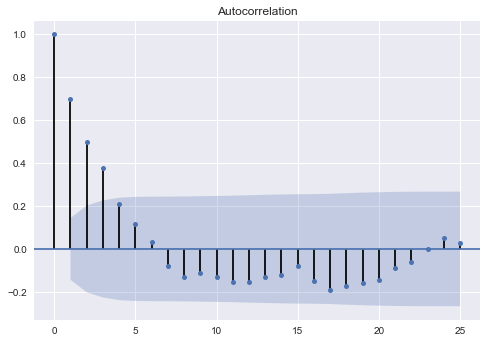

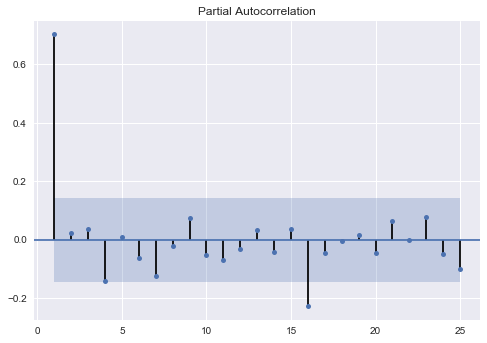

In [111]:
sm.tsa.graphics.plot_acf(price_df_ft1.Calculated.values, lags=25, zero=True)
plt.show()
sm.tsa.graphics.plot_pacf(price_df_ft1.Calculated.values, lags=25, zero=False)
plt.show()